<a href="https://colab.research.google.com/github/stiwari-ds/data-science-competitions/blob/main/dphi/ds90/notebooks/00_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [73]:
import gc
import os
import warnings

gc.enable()
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np

pd.set_option('precision', 4)
np.set_printoptions(precision=4)

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

SEED = 23
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

In [74]:
data_url = 'https://raw.githubusercontent.com/stiwari-ds/data-science-competitions/main/dphi/ds90/data'

train = pd.read_csv(f'{data_url}/raw/train.csv')
test = pd.read_csv(f'{data_url}/raw/test.csv')

In [75]:
train.head()

,decile3,decile1,sex,lsat,ugpa,grad,fulltime,fam_inc,parttime,male,race1,tier,decile1b,pass_bar
0,9.0,8.0,1.0,40.0,3.7,0,1.0,4.0,0.0,0.0,4,4.0,8.0,1
1,2.0,2.0,1.0,39.0,3.5,0,1.0,4.0,0.0,0.0,4,4.0,2.0,1
2,3.0,3.0,2.0,34.0,2.8,0,1.0,3.0,0.0,1.0,4,2.0,3.0,1
3,8.0,7.0,1.0,39.0,2.8,0,2.0,3.0,1.0,0.0,4,3.0,7.0,1
4,6.0,1.0,1.0,42.0,3.7,0,2.0,3.0,1.0,0.0,4,3.0,1.0,1


In [76]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   decile3   5000 non-null   float64
 1   decile1   5000 non-null   float64
 2   sex       5000 non-null   float64
 3   lsat      5000 non-null   float64
 4   ugpa      5000 non-null   float64
 5   grad      5000 non-null   int64  
 6   fulltime  5000 non-null   float64
 7   fam_inc   5000 non-null   float64
 8   parttime  5000 non-null   float64
 9   male      5000 non-null   float64
 10  race1     5000 non-null   int64  
 11  tier      5000 non-null   float64
 12  decile1b  5000 non-null   float64
 13  pass_bar  5000 non-null   int64  
dtypes: float64(11), int64(3)
memory usage: 547.0 KB


In [77]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   decile3   5000 non-null   float64
 1   decile1   5000 non-null   float64
 2   sex       5000 non-null   float64
 3   lsat      5000 non-null   float64
 4   ugpa      5000 non-null   float64
 5   grad      5000 non-null   int64  
 6   fulltime  5000 non-null   float64
 7   fam_inc   5000 non-null   float64
 8   parttime  5000 non-null   float64
 9   male      5000 non-null   float64
 10  race1     5000 non-null   int64  
 11  tier      5000 non-null   float64
 12  decile1b  5000 non-null   float64
dtypes: float64(11), int64(2)
memory usage: 507.9 KB


In [78]:
train.isna().sum().sum(), test.isna().sum().sum()

(0, 0)

# Target: pass_bar

In [79]:
TARGET= 'pass_bar'

In [80]:
train[TARGET].value_counts(normalize=True)

1    0.9504
0    0.0496
Name: pass_bar, dtype: float64

In [81]:
# dummy_sub = pd.DataFrame({'pass_bar': np.ones(5000)})
# dummy_sub.to_csv('dummy_sub.csv', index=False)

# Features

Data dictionary:
* ugpa - undergraduate gpa. 
* decile1, decile1b, decile3 - These features represent the law school rankings by decile of each candidate in years 1 and 3
* lsat - LSAT score of each candidate
* grad - indicates that the student who took the bar exam graduated from law school or not.
* fulltime - Was the student a full-time student.
* fam_inc - This feature is family income by quintile.
* tier - What tier law school did the student attend by quintile.
* race1 - Categorizes students by race.
* sex - student gender.
* pass_bar - whether the student passed the bar exam or not


### Visualization utils

In [82]:
def plot_cont(feature):
    """Plot side-by-side kdeplots for train and test
    data distribution of continuous feature.
    """
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(20,3))
    plt.suptitle(f'Feature distribution: {feature}')
    sns.kdeplot(x=feature, data=train, ax=ax[0], cut=0)
    ax[0].set_title('Train data')
    sns.kdeplot(x=feature, data=test, ax=ax[1], cut=0)
    ax[1].set_title('Test data')
    plt.show()

In [83]:
def plot_cat(feature):
    """Plot side-by-side countplots for train and test
    data distribution of categorical feature.
    """
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(20,3))
    plt.suptitle(f'Feature distribution: {feature}')
    sns.countplot(x=feature, data=train, ax=ax[0])
    ax[0].set_title('Train data')
    sns.countplot(x=feature, data=test, ax=ax[1])
    ax[1].set_title('Test data')
    plt.show()

In [84]:
def plot_cont_vs_target(feature):
    """Plot kdeplot for continuous feature split by
    Target categories.
    """
    plt.figure(figsize=(12, 3))
    plt.suptitle(f'{feature} split by {TARGET}')
    sns.kdeplot(x=feature, data=train, hue=TARGET, cut=0)
    plt.show()

### deciles

In [85]:
deciles = ['decile3', 'decile1', 'decile1b']

In [86]:
for col in deciles:
    print(f'{train[col].nunique()} , {sorted(train[col].unique())}') 

10 , [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
10 , [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
10 , [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]


In [87]:
train[deciles] = train[deciles].astype('uint8')
test[deciles] = test[deciles].astype('uint8')

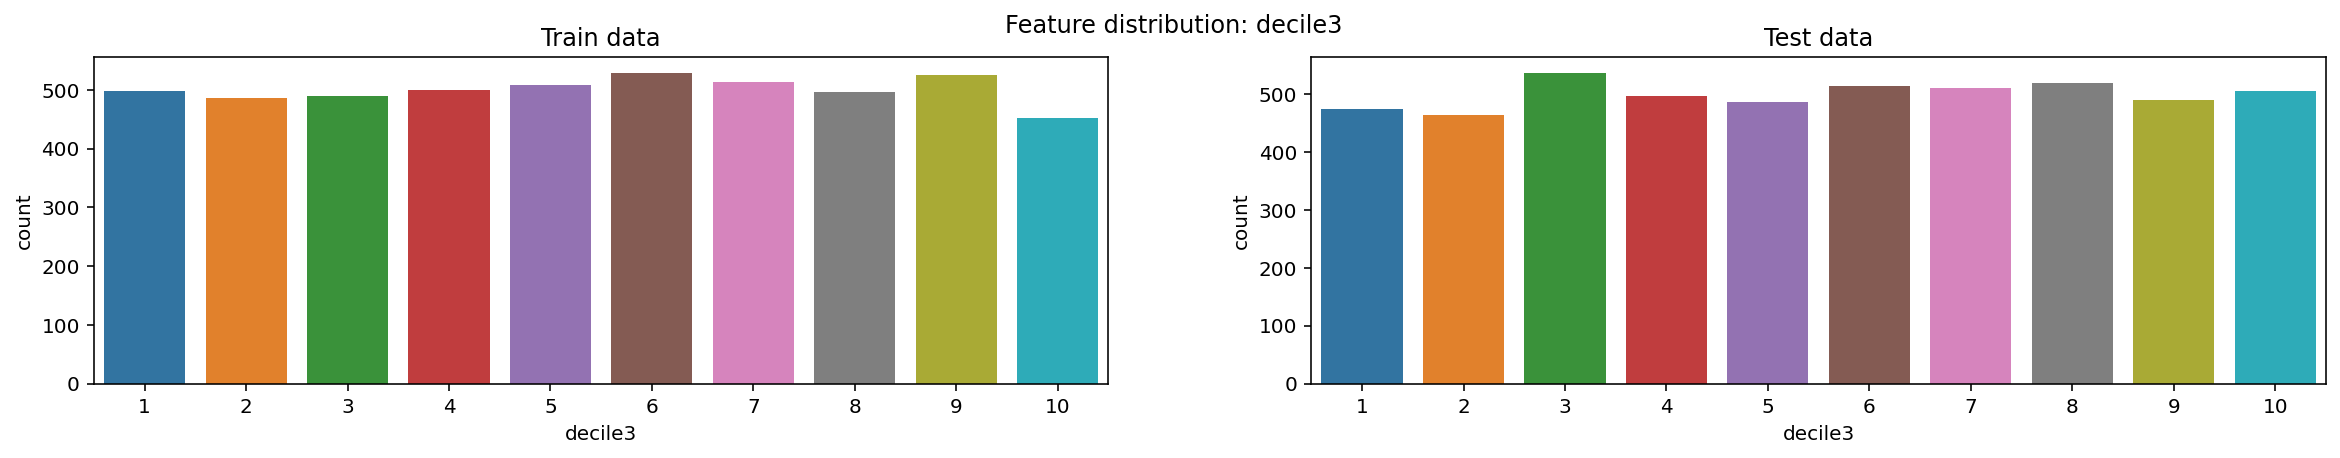

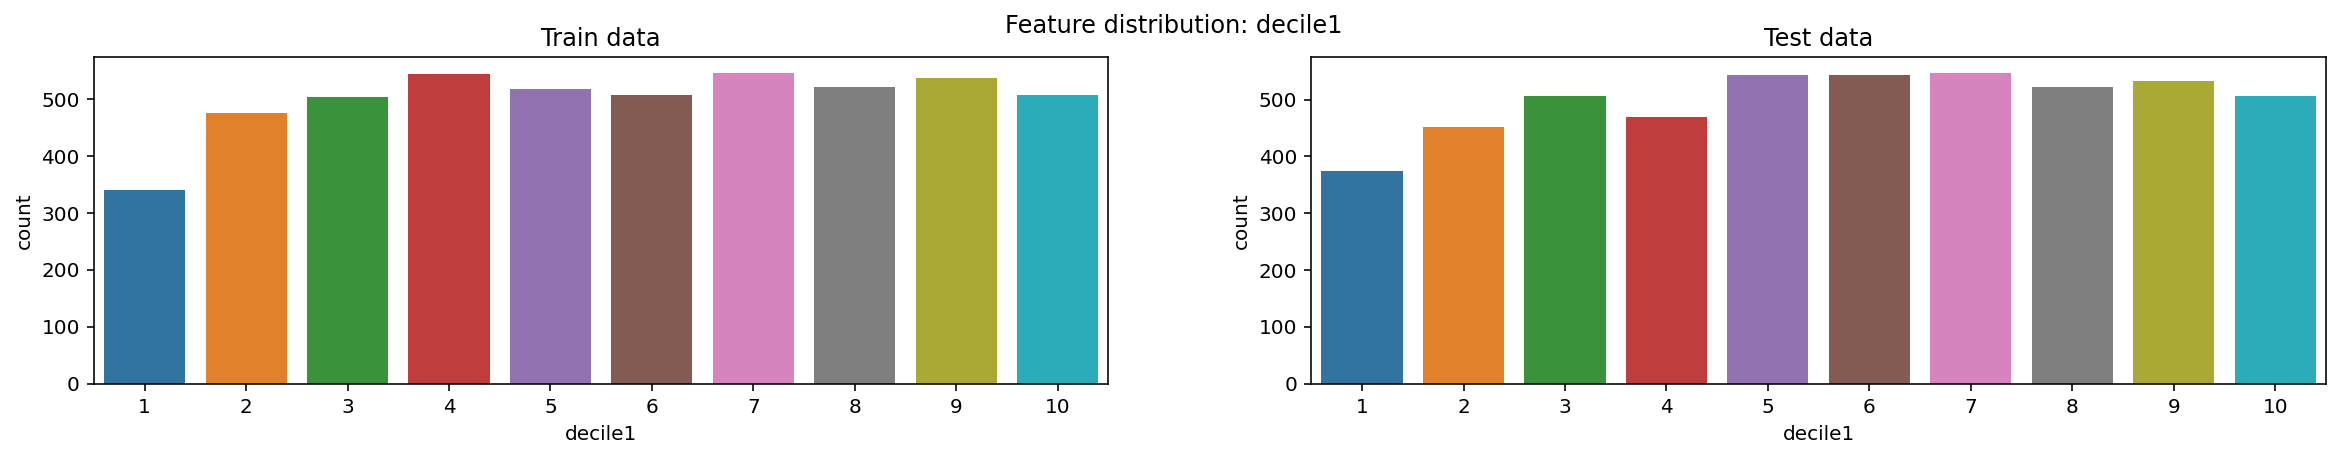

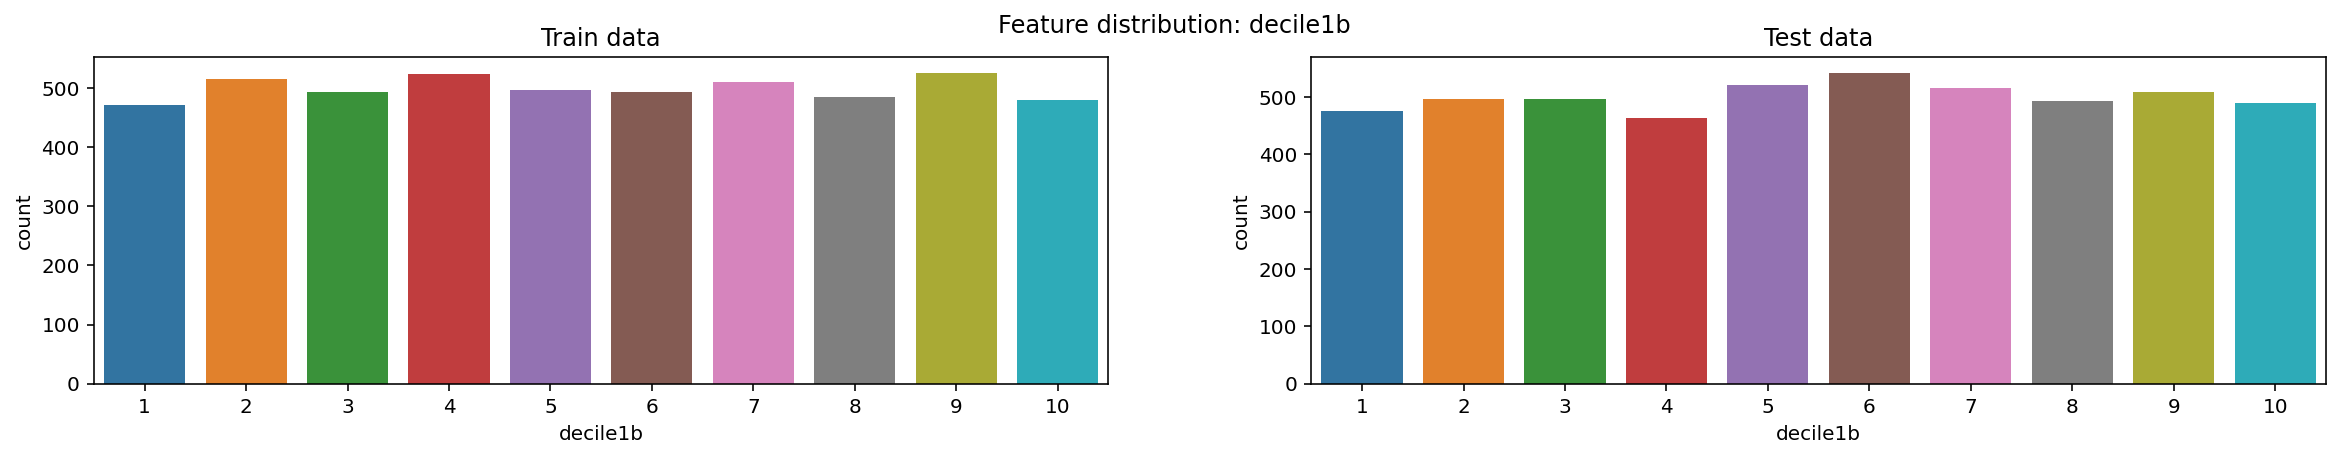

In [88]:
for col in deciles:
    plot_cat(col)

In [89]:
train[deciles].corr()

,decile3,decile1,decile1b
decile3,1.0000,0.8607,0.8621
decile1,0.8607,1.0000,0.9906
decile1b,0.8621,0.9906,1.0000


In [90]:
train[deciles].corrwith(train[TARGET])

decile3     0.2585
decile1     0.2233
decile1b    0.2280
dtype: float64

In [91]:
train = train.drop('decile1b', axis=1)
test = test.drop('decile1b', axis=1)

### sex, male

In [92]:
train.sex.unique(), train.male.unique()

(array([1., 2.]), array([0., 1.]))

In [93]:
test.sex.unique(), test.male.unique()

(array([1., 2.]), array([0., 1.]))

In [94]:
train[['sex']].corrwith(train['male'])

sex    1.0
dtype: float64

In [95]:
test[['sex']].corrwith(test['male'])

sex    1.0
dtype: float64

In [96]:
train = train.drop('sex', axis=1)
test = test.drop('sex', axis=1)

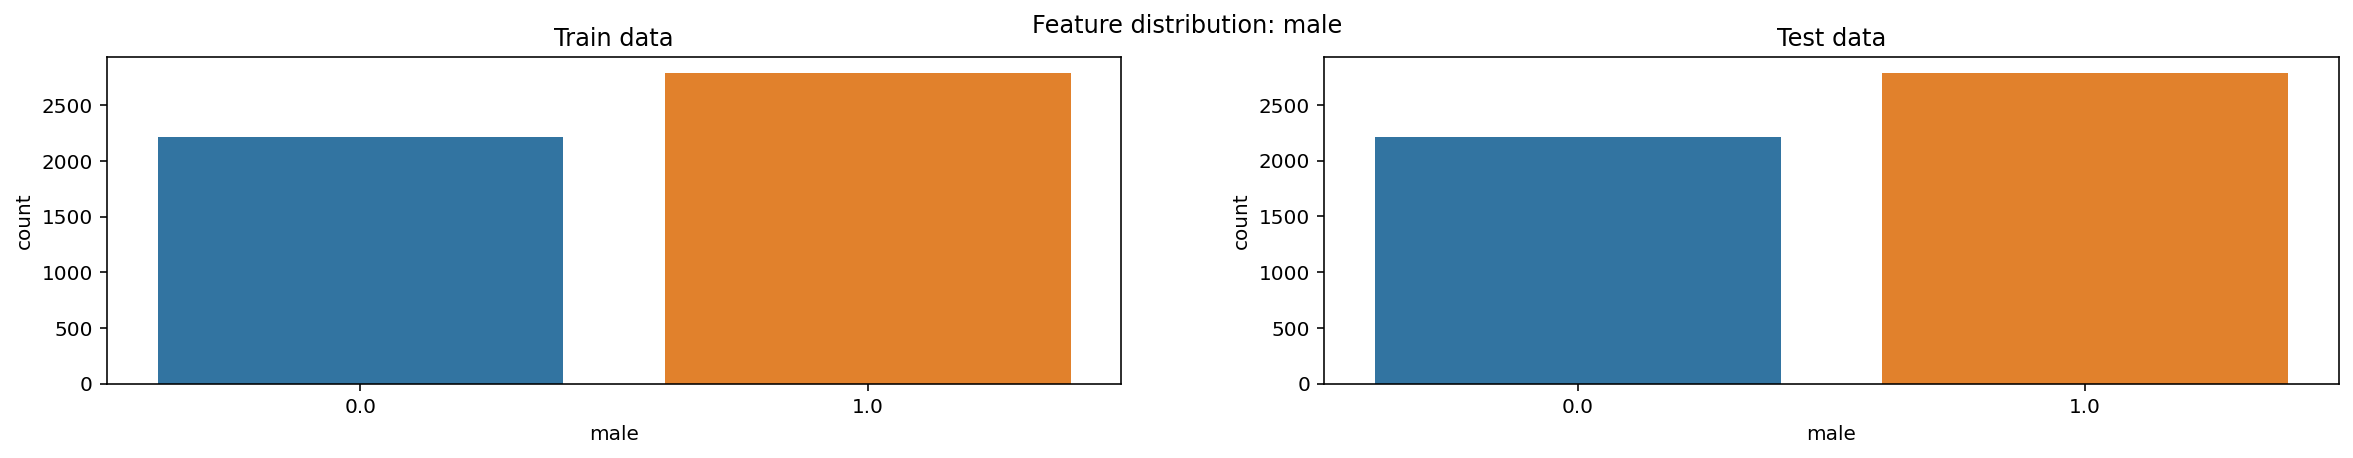

In [97]:
plot_cat('male')

In [98]:
train[['male']].corrwith(train[TARGET])

male    0.021
dtype: float64

In [99]:
train.groupby('male')[TARGET].value_counts(normalize=True)

male  pass_bar
0.0   1           0.9453
      0           0.0547
1.0   1           0.9545
      0           0.0455
Name: pass_bar, dtype: float64

In [100]:
train['male'] = train['male'].astype('uint8')
test['male'] = test['male'].astype('uint8')

### fulltime, parttime

In [101]:
train.fulltime.unique(), train.parttime.unique()

(array([1., 2.]), array([0., 1.]))

In [102]:
test.fulltime.unique(), test.parttime.unique()

(array([1., 2.]), array([0., 1.]))

In [103]:
train[['fulltime']].corrwith(train['parttime'])

fulltime    1.0
dtype: float64

In [104]:
test[['fulltime']].corrwith(test['parttime'])

fulltime    1.0
dtype: float64

In [105]:
train = train.drop('fulltime', axis=1)
test = test.drop('fulltime', axis=1)

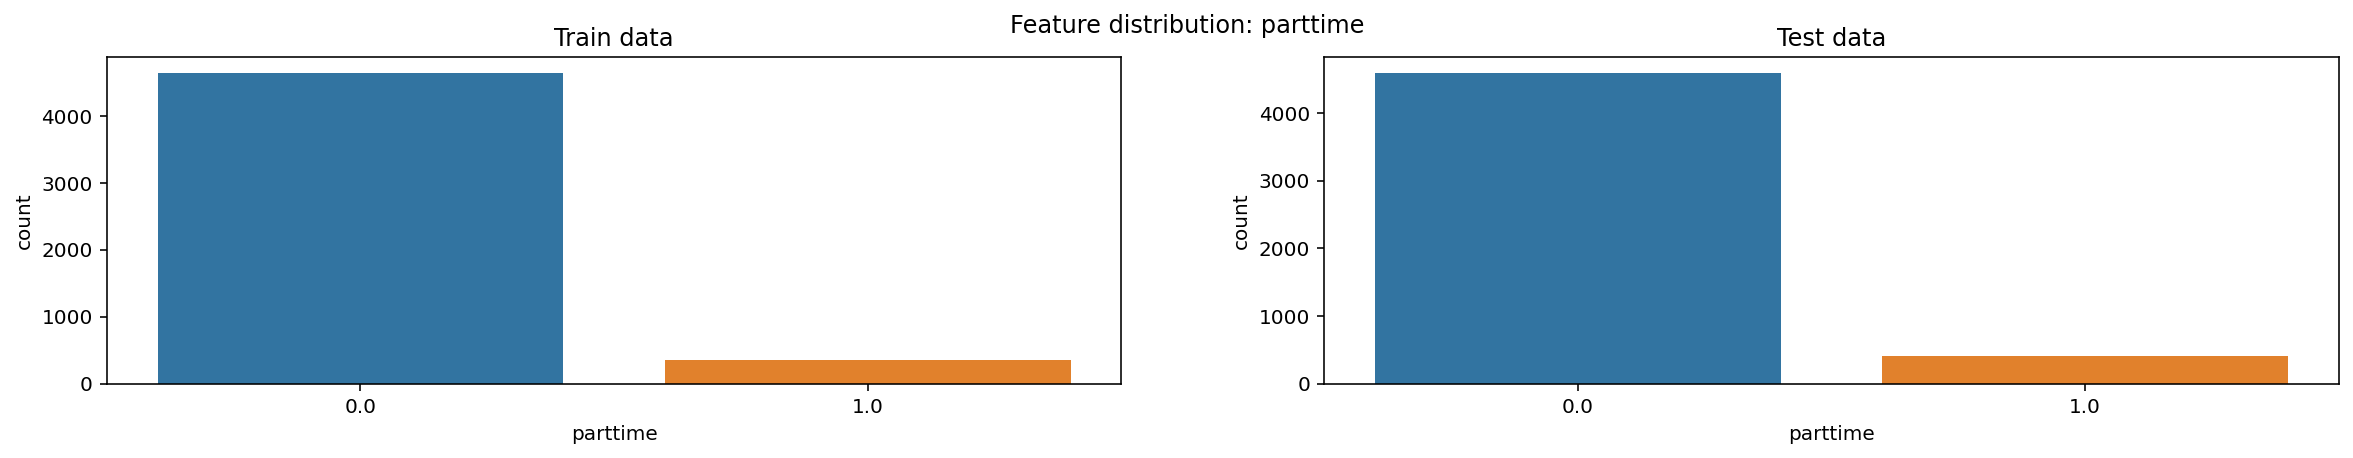

In [106]:
plot_cat('parttime')

In [107]:
train[['parttime']].corrwith(train[TARGET])

parttime   -0.0866
dtype: float64

In [108]:
train.groupby('parttime')[TARGET].value_counts(normalize=True)

parttime  pass_bar
0.0       1           0.9556
          0           0.0444
1.0       1           0.8827
          0           0.1173
Name: pass_bar, dtype: float64

In [109]:
train['parttime'] = train['parttime'].astype('uint8')
test['parttime'] = test['parttime'].astype('uint8')

### race1

In [110]:
train['race1'].unique(), test['race1'].unique()

(array([4, 0, 3, 1, 2]), array([4, 2, 0, 3, 1]))

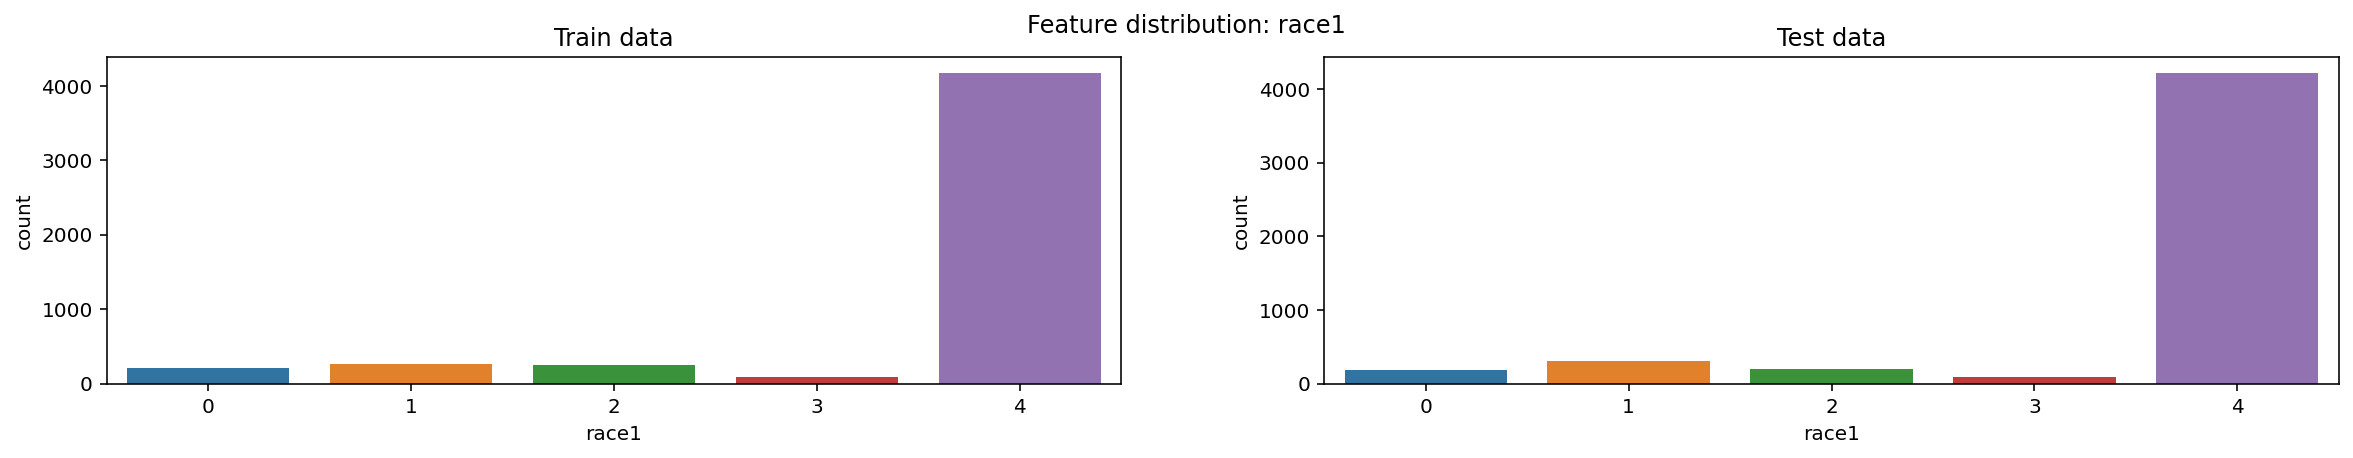

In [111]:
plot_cat('race1')

In [112]:
train[['race1']].corrwith(train[TARGET])

race1    0.1512
dtype: float64

In [113]:
train.groupby('race1')[TARGET].value_counts(normalize=True)

race1  pass_bar
0      1           0.9387
       0           0.0613
1      1           0.7741
       0           0.2259
2      1           0.9040
       0           0.0960
3      1           0.9255
       0           0.0745
4      1           0.9657
       0           0.0343
Name: pass_bar, dtype: float64

In [114]:
train['race1'] = train['race1'].astype('uint8')
test['race1'] = test['race1'].astype('uint8')

### tier

In [115]:
train['tier'].unique(), test['tier'].unique()

(array([4., 2., 3., 5., 6., 1.]), array([3., 6., 4., 5., 2., 1.]))

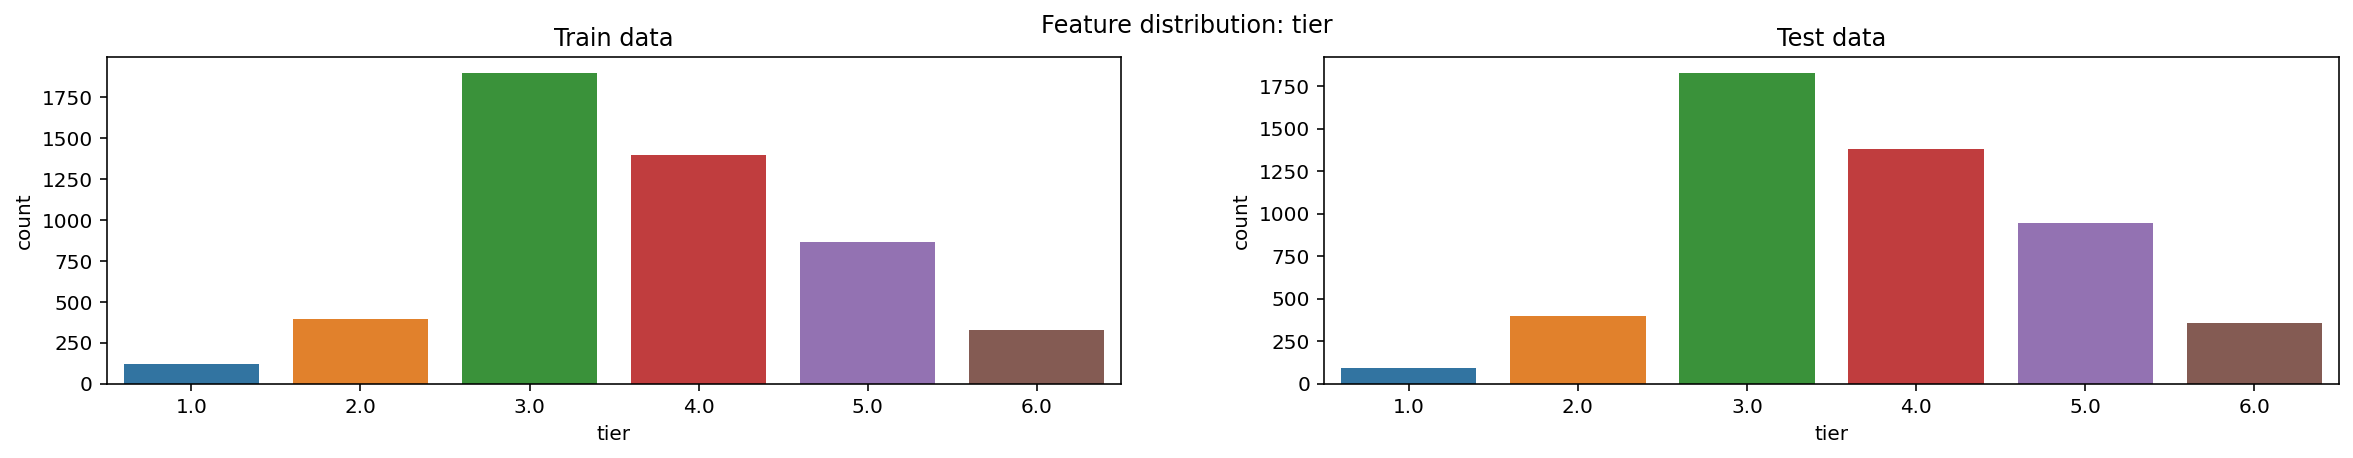

In [116]:
plot_cat('tier')

In [117]:
train[['tier']].corrwith(train[TARGET])

tier    0.1071
dtype: float64

In [118]:
train.groupby('tier')[TARGET].value_counts(normalize=True)

tier  pass_bar
1.0   1           0.7458
      0           0.2542
2.0   1           0.9144
      0           0.0856
3.0   1           0.9489
      0           0.0511
4.0   1           0.9685
      0           0.0315
5.0   1           0.9572
      0           0.0428
6.0   1           0.9815
      0           0.0185
Name: pass_bar, dtype: float64

In [119]:
train['tier'] = train['tier'].astype('uint8')
test['tier'] = test['tier'].astype('uint8')

### grad

In [120]:
train['grad'].unique(), test['grad'].unique()

(array([0]), array([0]))

In [121]:
train = train.drop('grad', axis=1)
test = test.drop('grad', axis=1)

### fam_inc

In [122]:
train['fam_inc'].unique(), test['fam_inc'].unique()

(array([4., 3., 5., 1., 2.]), array([3., 4., 2., 5., 1.]))

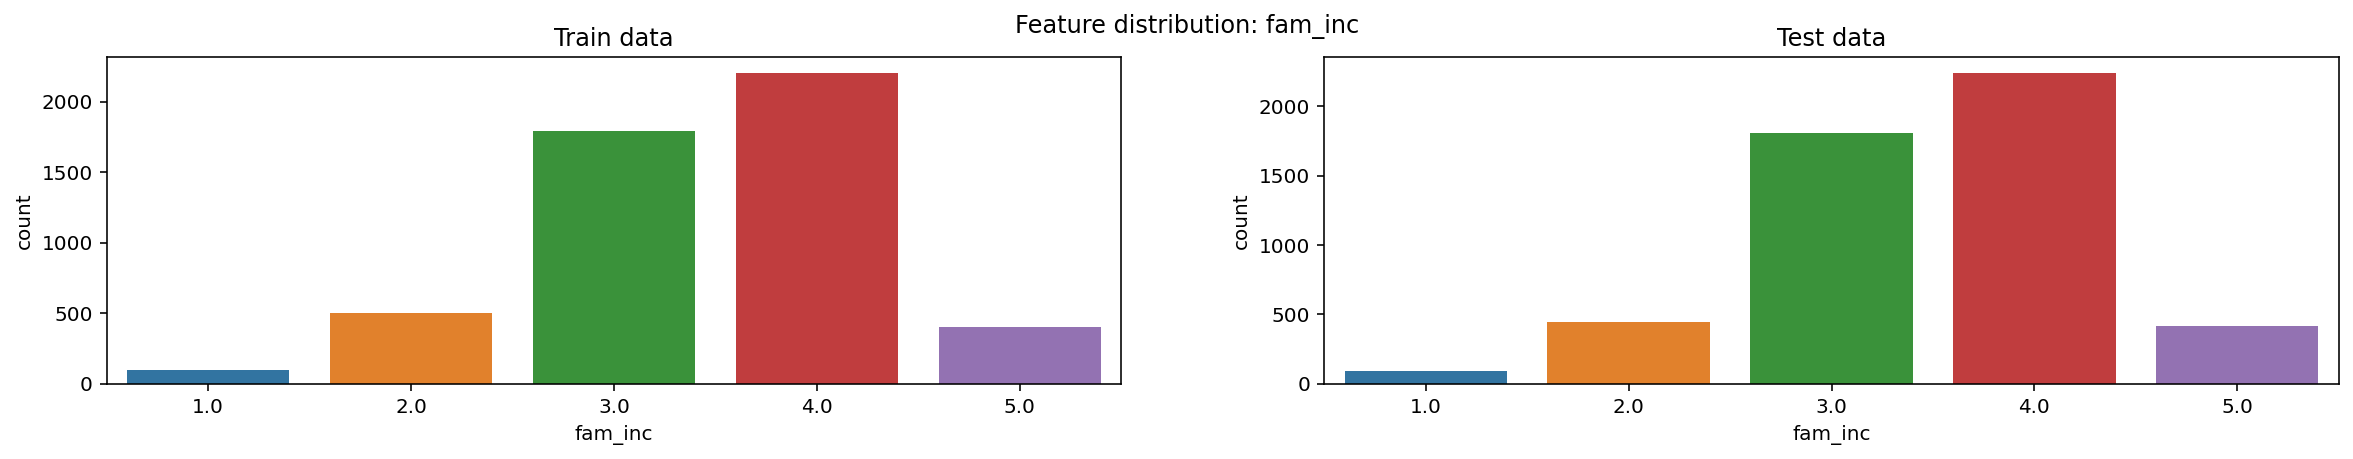

In [123]:
plot_cat('fam_inc')

In [124]:
train[['fam_inc']].corrwith(train[TARGET])

fam_inc    0.0678
dtype: float64

In [125]:
train.groupby('fam_inc')[TARGET].value_counts(normalize=True)

fam_inc  pass_bar
1.0      1           0.8980
         0           0.1020
2.0      1           0.9220
         0           0.0780
3.0      1           0.9415
         0           0.0585
4.0      1           0.9650
         0           0.0350
5.0      1           0.9579
         0           0.0421
Name: pass_bar, dtype: float64

In [126]:
train['fam_inc'] = train['fam_inc'].astype('uint8')
test['fam_inc'] = test['fam_inc'].astype('uint8')

### ugpa

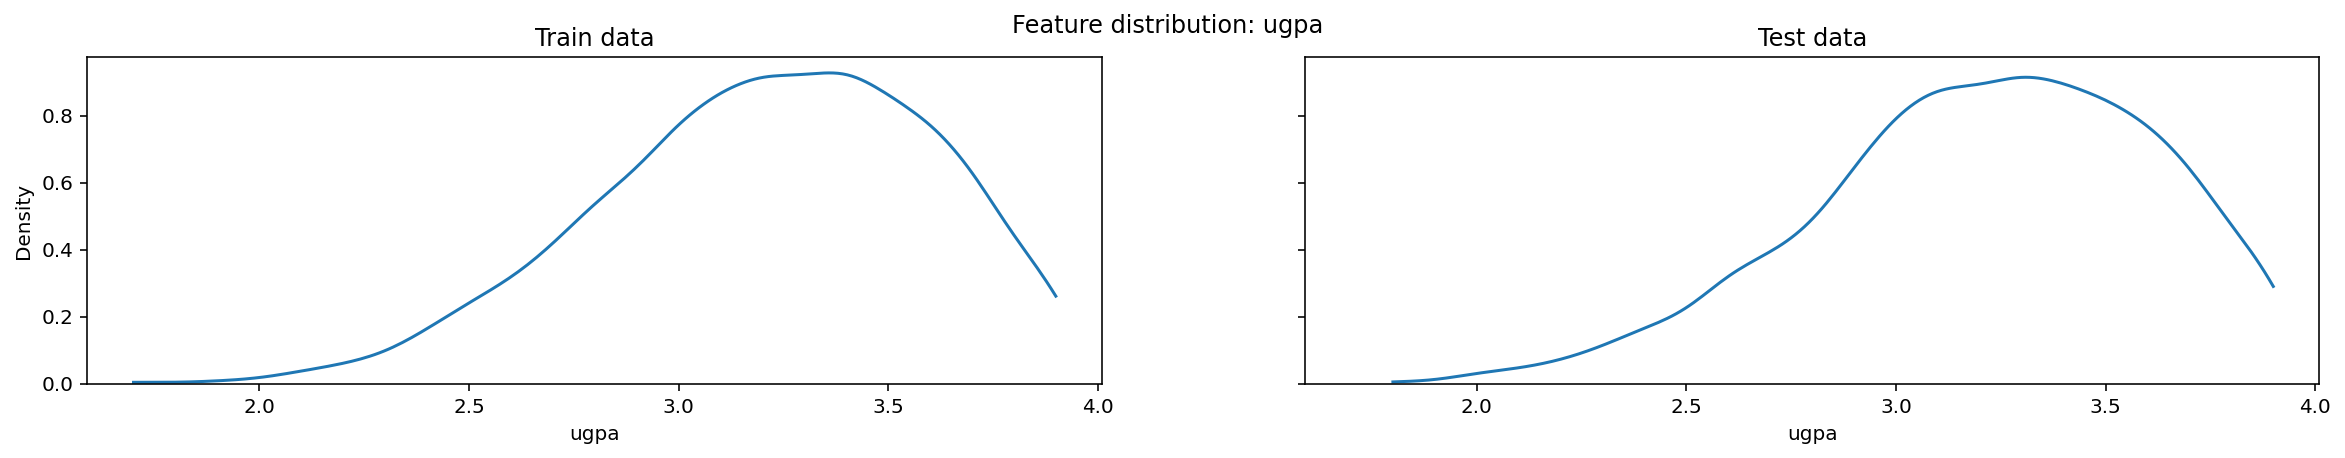

In [127]:
plot_cont('ugpa')

In [128]:
train['ugpa'].min(), train['ugpa'].max()

(1.7, 3.9)

In [129]:
test['ugpa'].min(), test['ugpa'].max()

(1.8, 3.9)

In [130]:
train[['ugpa']].corrwith(train[TARGET])

ugpa    0.1328
dtype: float64

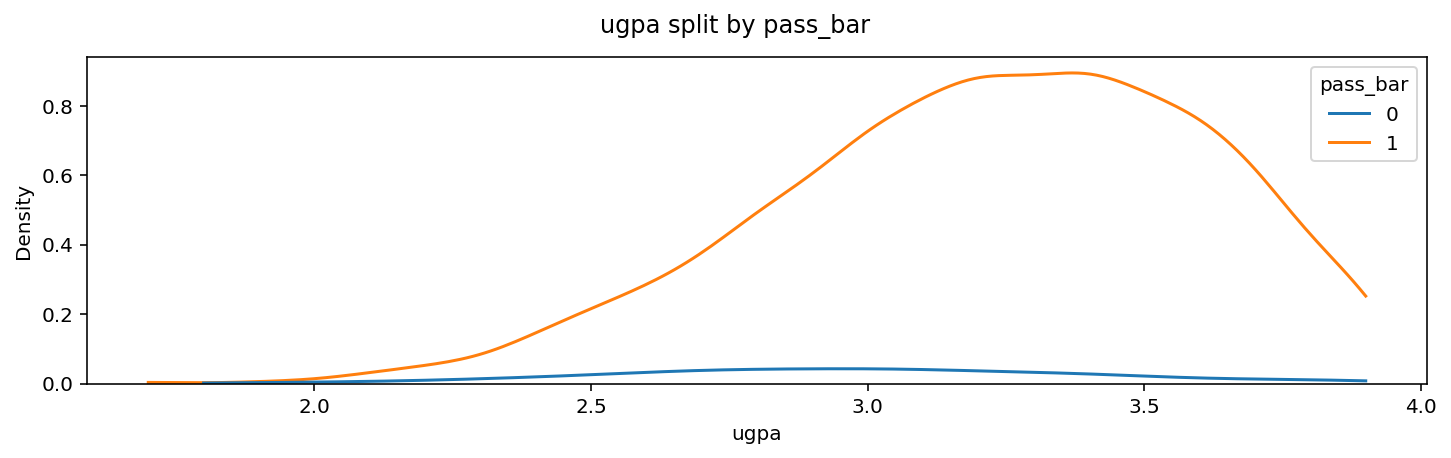

In [131]:
plot_cont_vs_target('ugpa')

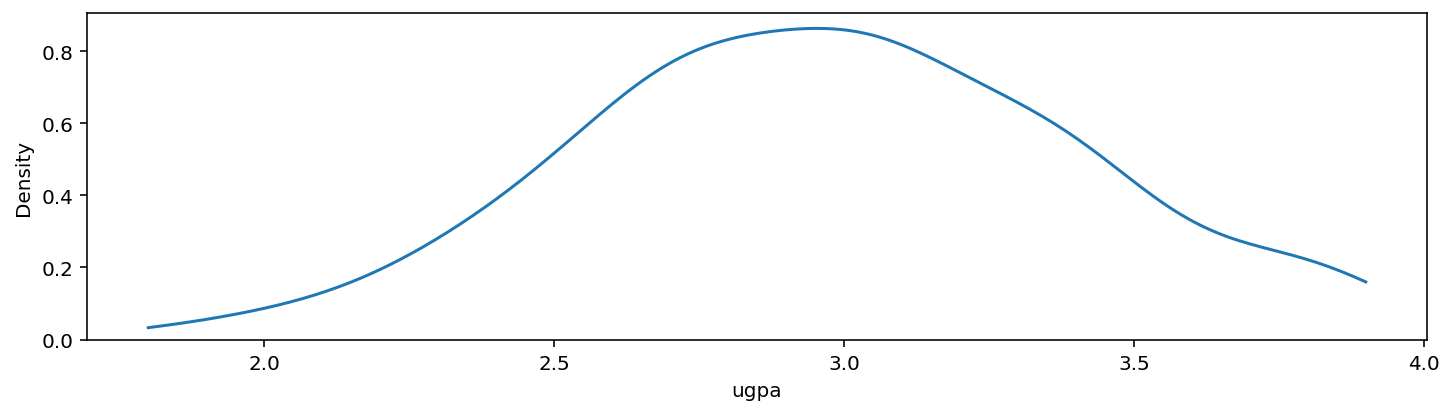

In [132]:
plt.figure(figsize=(12,3))
sns.kdeplot(x='ugpa', data=train.loc[train[TARGET] == 0], cut=0)
plt.show()

Slightly lower 'ugpa' peak for 'pass_bar' class = 0.

In [133]:
train.groupby(TARGET)['ugpa'].agg(['min', 'max', 'mean', 'median'])

,min,max,mean,median
pass_bar,,,,
0,1.8,3.9,2.9782,3.0
1,1.7,3.9,3.2198,3.2


### lsat

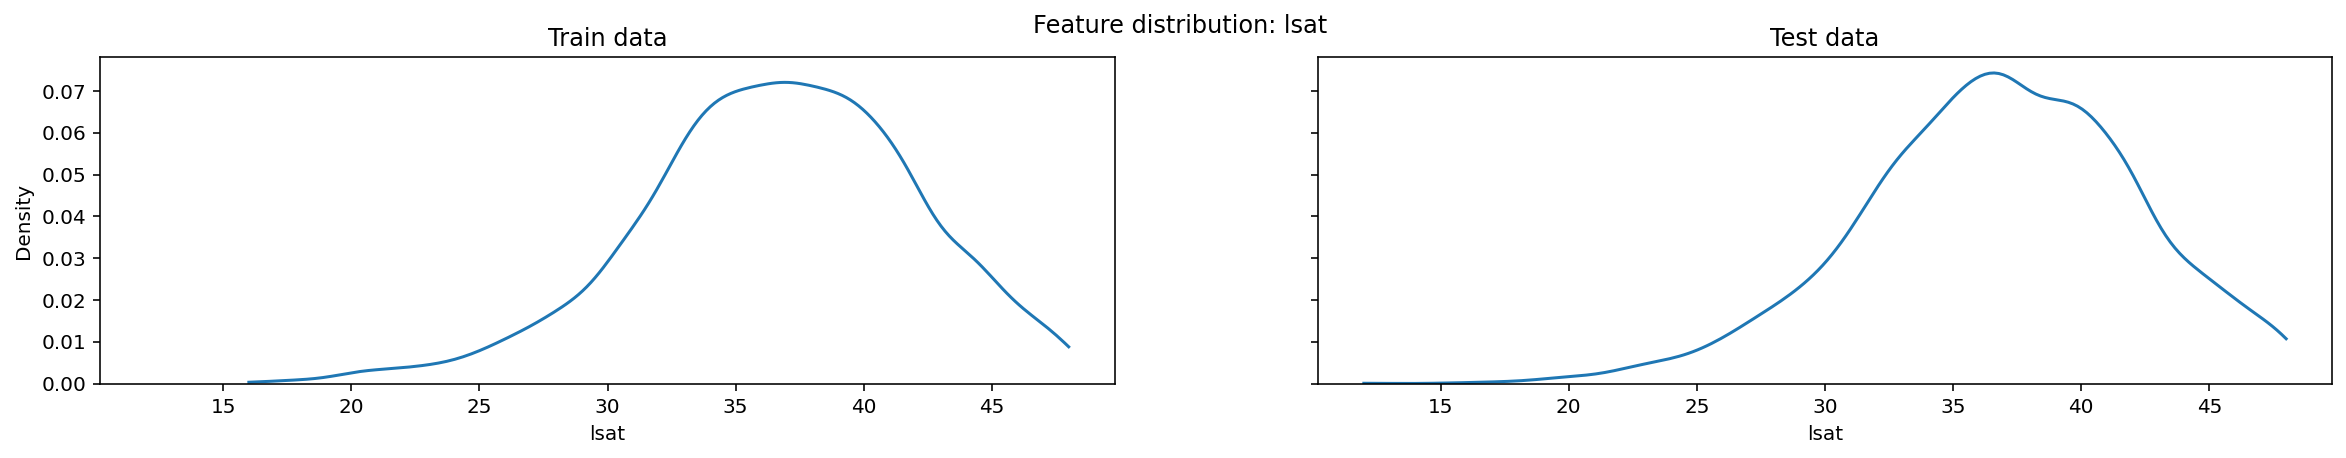

In [134]:
plot_cont('lsat')

In [135]:
train['lsat'].min(), train['lsat'].max()

(16.0, 48.0)

In [136]:
test['lsat'].min(), test['lsat'].max()

(12.0, 48.0)

In [137]:
train[['lsat']].corrwith(train[TARGET])

lsat    0.2472
dtype: float64

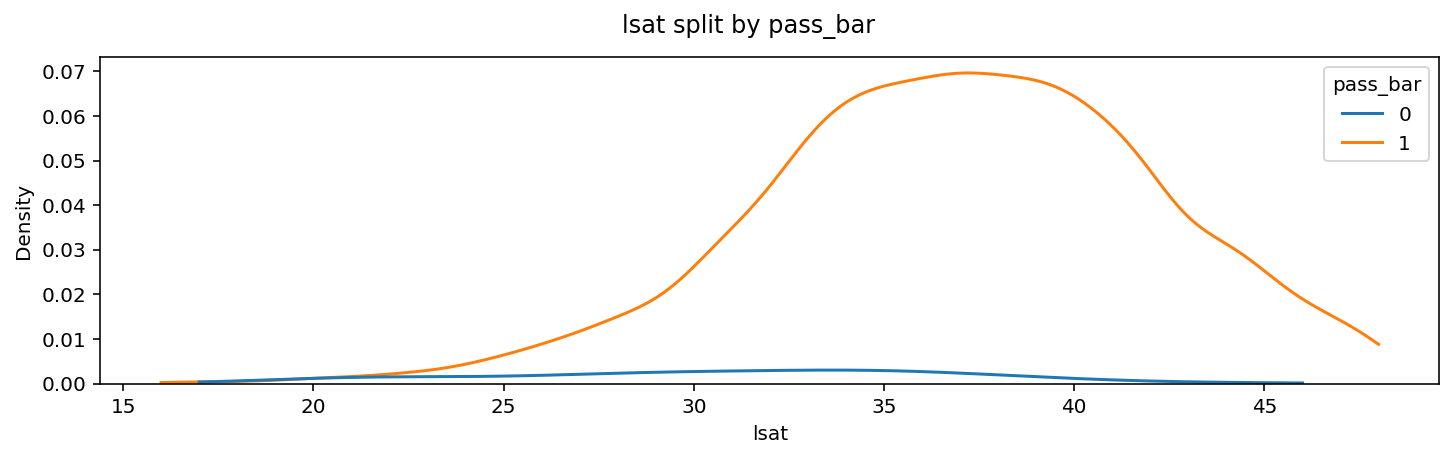

In [138]:
plot_cont_vs_target('lsat')

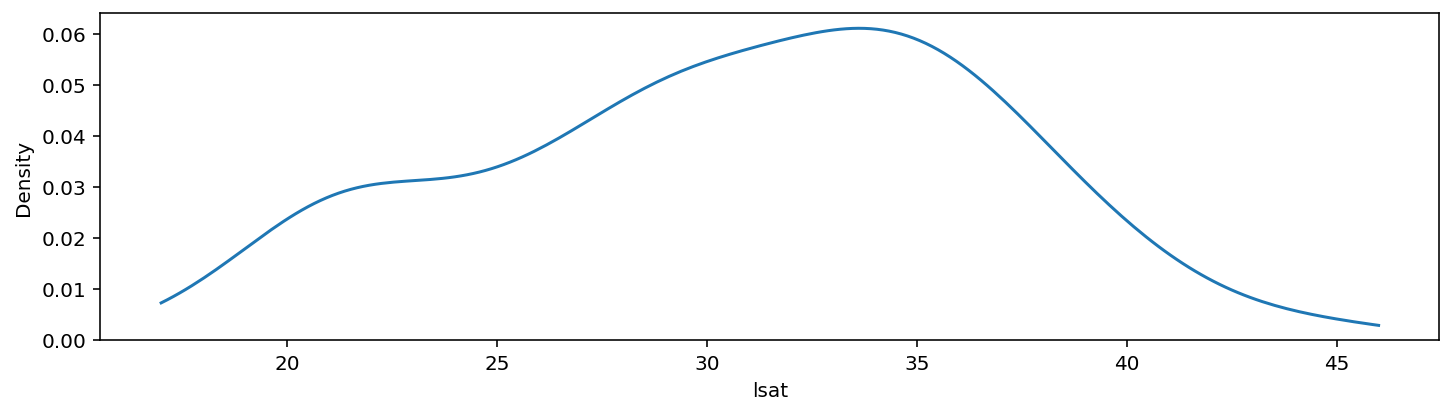

In [139]:
plt.figure(figsize=(12,3))
sns.kdeplot(x='lsat', data=train.loc[train[TARGET] == 0], cut=0)
plt.show()

Higher density at low 'lsat' for 'pass_bar' class = 0.

In [140]:
train.groupby(TARGET)['lsat'].agg(['min', 'max', 'mean', 'median'])

,min,max,mean,median
pass_bar,,,,
0,17.0,46.0,30.7923,31.25
1,16.0,48.0,36.9449,37.00


# Feature selection

In [141]:
features = list(test.columns)
num_features = ['lsat', 'ugpa']
cat_features = [f for f in features if f not in num_features]

### Pearson correlation

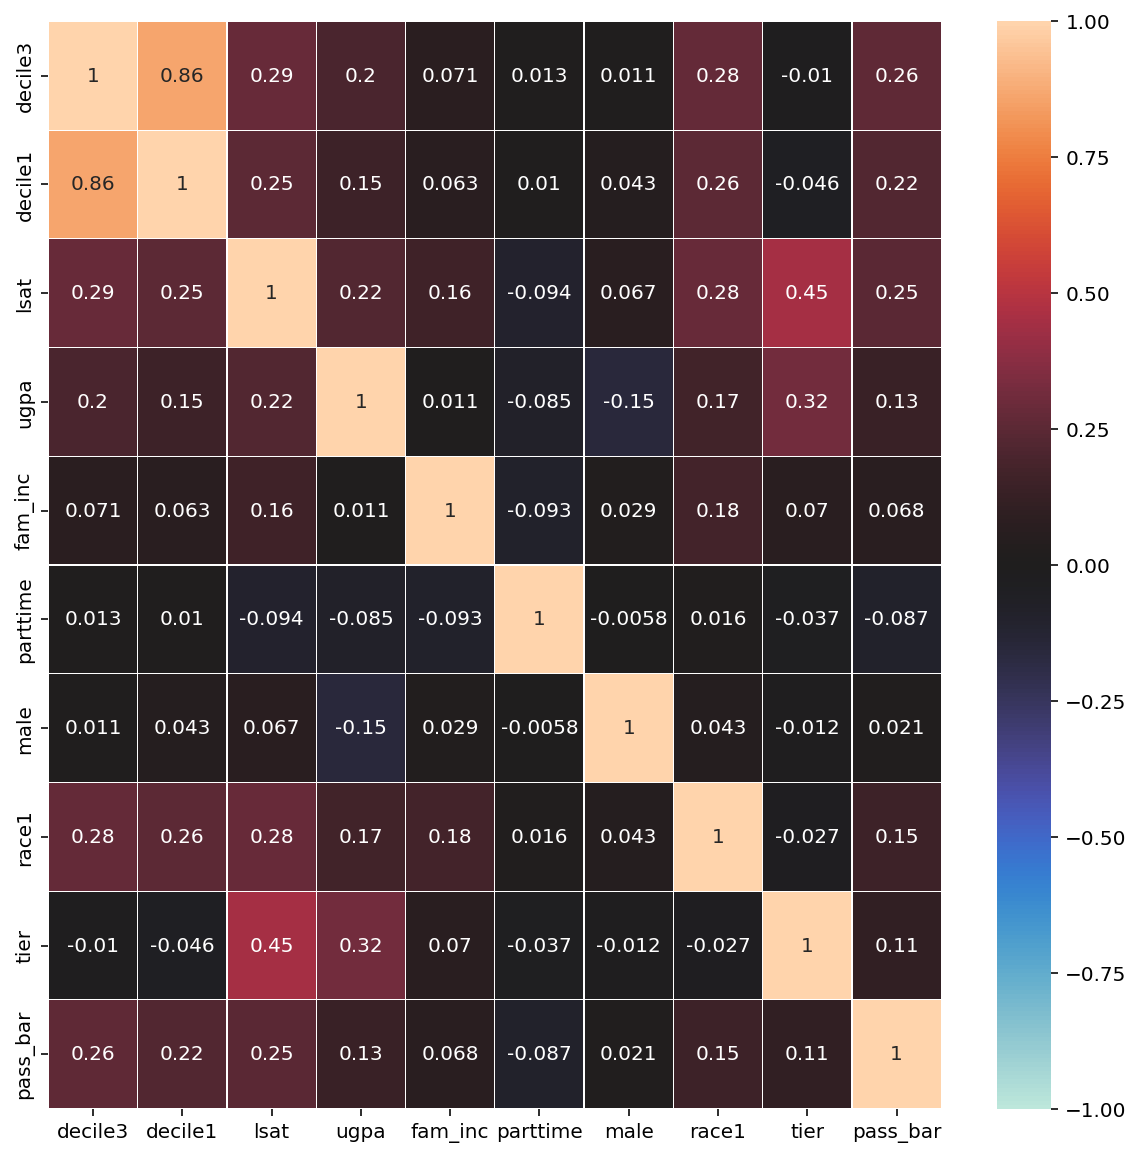

In [142]:
corr_df = train.corr(method='pearson')
plt.figure(figsize=(10, 10))
sns.heatmap(corr_df, vmin=-1, vmax=1, center=0, annot=True, linewidths=0.1)
plt.show()

### Kendall Tau correlation

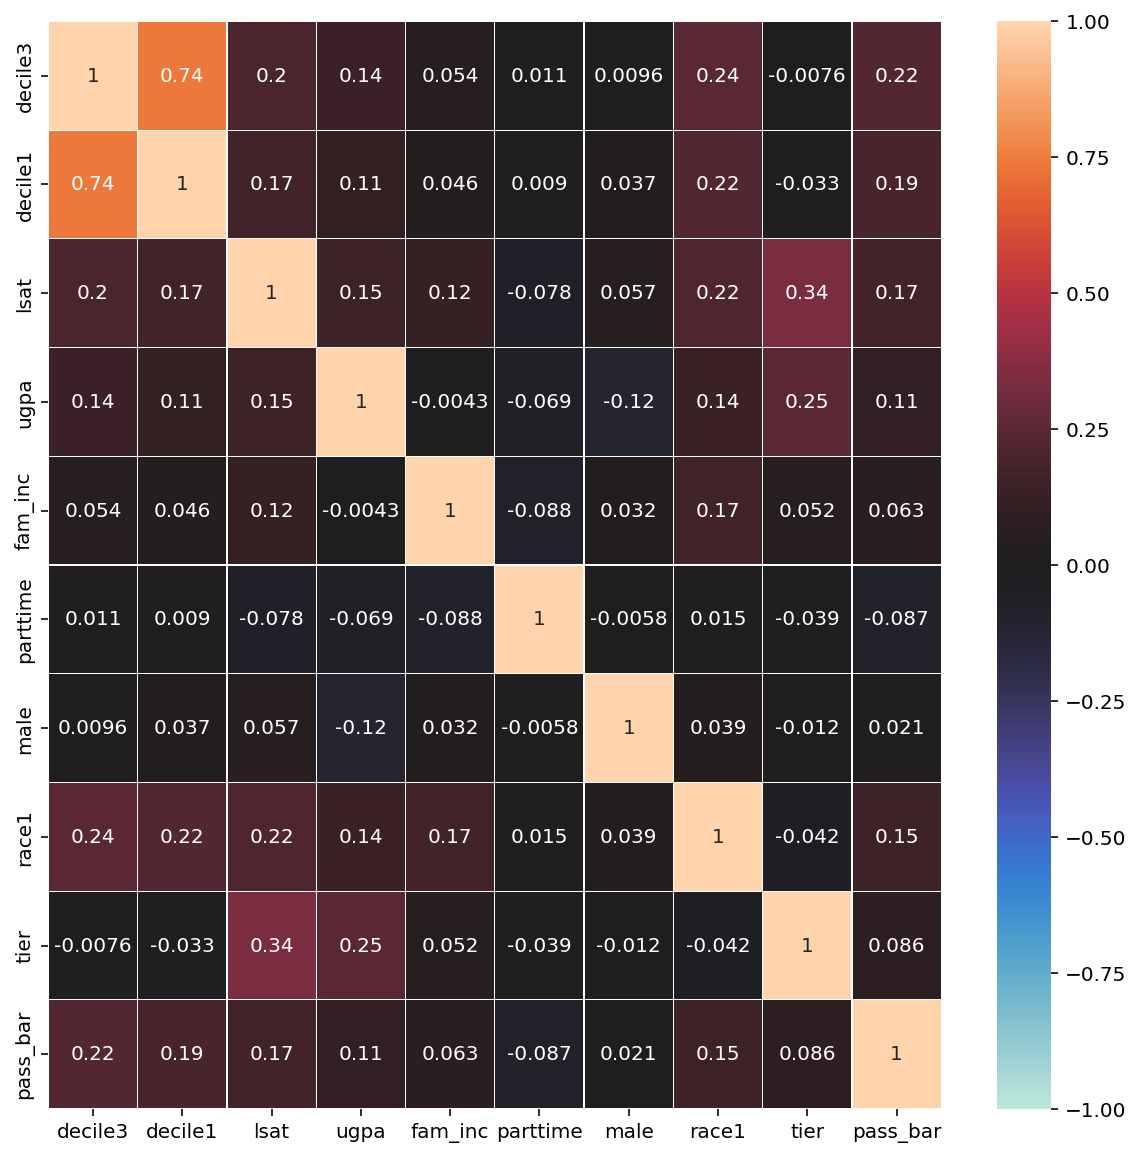

In [143]:
corr_df = train.corr(method='kendall')
plt.figure(figsize=(10, 10))
sns.heatmap(corr_df, vmin=-1, vmax=1, center=0, annot=True, linewidths=0.1)
plt.show()

### Spearman rank correlation

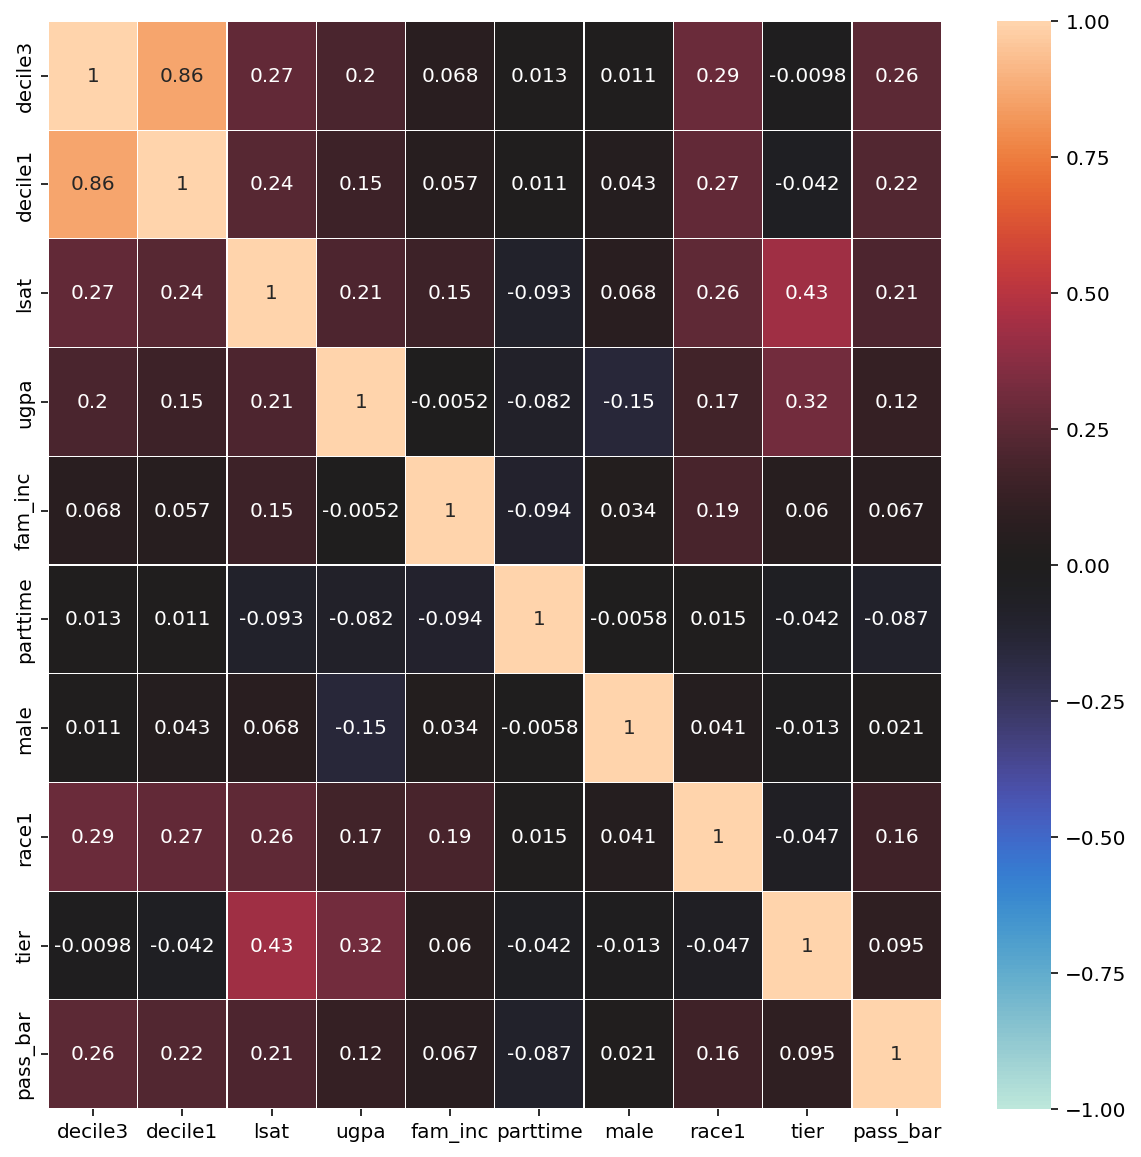

In [144]:
corr_df = train.corr(method='spearman')
plt.figure(figsize=(10, 10))
sns.heatmap(corr_df, vmin=-1, vmax=1, center=0, annot=True, linewidths=0.1)
plt.show()

### Chi-square test of independence

In [145]:
chi2_test = chi2(train[cat_features], train[TARGET])

pd.DataFrame(
    data={
        'chi2-statistic': chi2_test[0], 
        'p-value': chi2_test[1],
        'accepted?': chi2_test[1] < 0.05
    },
    index=cat_features
)

,chi2-statistic,p-value,accepted?
decile3,490.3662,1.1861e-108,True
decile1,336.8049,3.1675e-75,True
fam_inc,4.8355,2.7880e-02,True
parttime,34.8264,3.6045e-09,True
male,0.9771,3.2290e-01,False
race1,37.9987,7.0791e-10,True
tier,19.3887,1.0664e-05,True


### ANOVA F-test (continuous feature - categorical target)

In [146]:
anova_test = f_classif(train[num_features], train[TARGET])

pd.DataFrame(
    data={
        'f-statistic': anova_test[0], 
        'p-value': anova_test[1],
        'accepted?': anova_test[1] < 0.05
    },
    index=num_features
)

,f-statistic,p-value,accepted?
lsat,325.3249,1.6547e-70,True
ugpa,89.7771,4.0056e-21,True


### Mutual Information score

In [148]:
cat_mask = [(f in cat_features) for f in features] #boolean mask for discrete features

mi_scores = mutual_info_classif(train[features], train[TARGET], 
                                discrete_features=cat_mask, 
                                random_state=SEED)

mi_score_percent = mi_scores / sum(mi_scores) * 100

pd.DataFrame(
    data={'mi_score': mi_scores},
    index=features
).T

,decile3,decile1,lsat,ugpa,fam_inc,parttime,male,race1,tier
mi_score,0.0405,0.0284,0.0275,0.0083,0.0026,0.0028,0.0002,0.0133,0.0085


# Processed datasets

In [151]:
train.to_csv('train_reduced.csv', index=False)
test.to_csv('test_reduced.csv', index=False)

In [152]:
!head train_reduced.csv

decile3,decile1,lsat,ugpa,fam_inc,parttime,male,race1,tier,pass_bar
9,8,40.0,3.7,4,0,0,4,4,1
2,2,39.0,3.5,4,0,0,4,4,1
3,3,34.0,2.8,3,0,1,4,2,1
8,7,39.0,2.8,3,1,0,4,3,1
6,1,42.0,3.7,3,1,0,4,3,1
6,8,35.0,3.0,4,0,1,4,5,1
9,10,38.0,3.4,4,0,1,4,6,1
4,4,33.0,3.3,3,0,0,4,4,1
7,7,41.0,3.5,3,0,0,4,4,1
